In [ ]:
# torchaudio test

In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

2.5.1
2.5.1a0


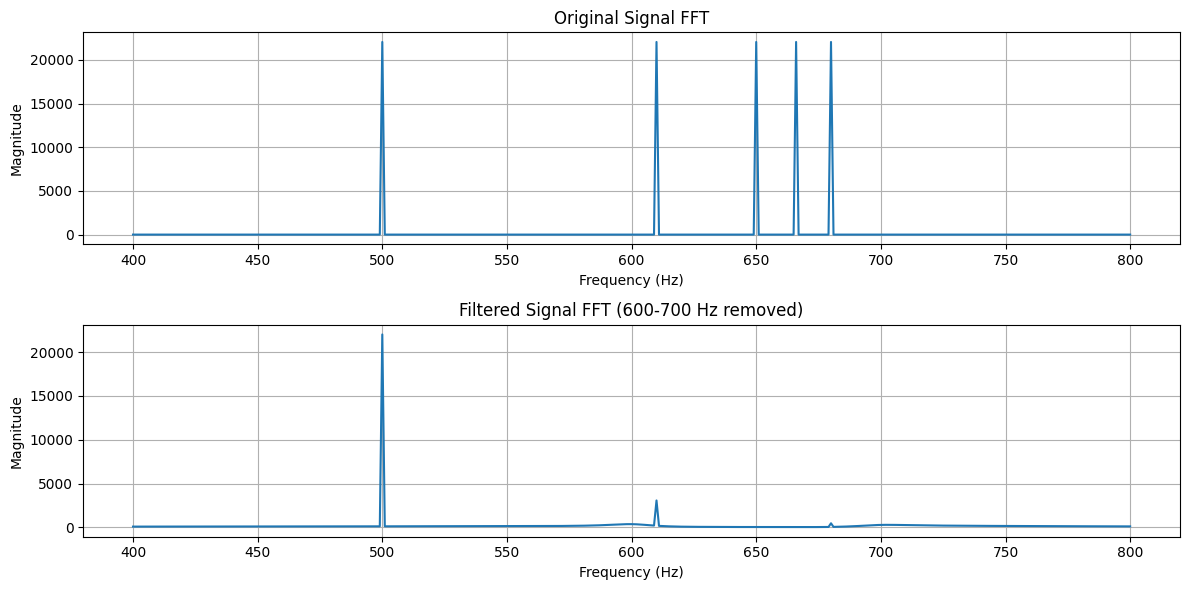

In [7]:
# notch filter, band stop filter for fan noise removal

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt

# Example signal generation
fs = 44100  # sampling rate in Hz
t = np.linspace(0, 1, fs, endpoint=False)

# Create a sample signal with noise at 650 Hz
signal = (np.sin(2*np.pi*500*t) +  # low freq signal
           # noise frequency to remove
          np.sin(2*np.pi*650*t) + np.sin(2*np.pi*680*t) +
           np.sin(2*np.pi*610*t) + np.sin(2*np.pi*666*t)
         )  

# Design a band-stop (notch) filter from 600 to 700 Hz
def bandstop_filter(lowcut, highcut, fs, order=8): # butterworth
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='bandstop', output='sos')
    return sos

# Create filter
sos = bandstop_filter(600, 700, fs)

# Apply filter
filtered_signal = sosfilt(sos, signal)

# Plot original and filtered signals in frequency domain
def plot_fft(signal, fs, title, freq_min=400, freq_max=800):
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    
    # Filter to only plot frequencies between freq_min and freq_max
    mask = (freqs >= freq_min) & (freqs <= freq_max)
    freqs_plot = freqs[mask]
    magnitude_plot = fft_magnitude[mask]
    
    plt.plot(freqs_plot, magnitude_plot)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plot_fft(signal, fs, 'Original Signal FFT')
plt.subplot(2,1,2)
plot_fft(filtered_signal, fs, 'Filtered Signal FFT (600-700 Hz removed)')
plt.tight_layout()
plt.show()

In [12]:
import torch
import torchaudio
from scipy.signal import butter, sosfilt
import numpy as np

# Load mp3
mp3_path = 'freemusictest.mp3'
waveform, sample_rate = torchaudio.load(mp3_path)  # waveform: [channels, samples]

# Convert to numpy for filtering per channel
filtered_channels = []
for ch in range(waveform.shape[0]):
    signal = waveform[ch].numpy()
    # Bandstop filter function
    def bandstop_filter(lowcut, highcut, fs, order=8):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], btype='bandstop', output='sos')
        return sos
    sos = bandstop_filter(600, 7000, sample_rate)
    filtered = sosfilt(sos, signal)
    filtered_channels.append(filtered)

# Stack filtered channels back into tensor [channels, samples]
filtered_waveform = torch.tensor(np.vstack(filtered_channels), dtype=torch.float32)

print(filtered_waveform.shape)  # should be [channels, samples]

# Save filtered audio as mp3
output_path = 'filtered_output.mp3'
torchaudio.save(output_path, filtered_waveform, sample_rate, encoding="MP3", format="mp3")
print(f"Filtered audio saved to {output_path}")

torch.Size([2, 5761152])
Filtered audio saved to filtered_output.mp3


In [ ]:
from pydub import AudioSegment
import numpy as np
from scipy.signal import butter, sosfilt
import io

# Load MP3 using pydub
mp3_path = 'freemusictest.mp3'
audio = AudioSegment.from_file(mp3_path, format="mp3")

# Convert to mono/stereo numpy array
samples = np.array(audio.get_array_of_samples())
channels = audio.channels
sample_rate = audio.frame_rate

# Reshape to (channels, samples)
if channels == 2:
    samples = samples.reshape((-1, 2)).T
else:
    samples = samples[np.newaxis, :]

# Bandstop filter function
def bandstop_filter(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='bandstop', output='sos')
    return sos

# Apply filter to each channel
filtered_channels = []
for ch in range(channels):
    signal = samples[ch].astype(np.float32)
    sos = bandstop_filter(600, 7000, sample_rate)
    filtered = sosfilt(sos, signal)
    filtered_channels.append(filtered)

# Combine filtered channels
filtered_audio_np = np.stack(filtered_channels, axis=0)

# Flatten interleaved format for pydub
if channels == 2:
    interleaved = np.column_stack(filtered_audio_np).astype(np.int16).flatten()
else:
    interleaved = filtered_audio_np[0].astype(np.int16)

# Create a new AudioSegment
filtered_audio = AudioSegment(
    interleaved.tobytes(),
    frame_rate=sample_rate,
    sample_width=2,
    channels=channels
)

# Save to MP3
output_path = 'filtered_output_dub.mp3'
filtered_audio.export(output_path, format="mp3")
print(f"Filtered audio saved to {output_path}")